## Internlm2.5 implemented from scratch with kvcache
in this file, i implemented intern2.5-7B from scratch, one tensor and matrix multiplication at a time.
<br><br>
the weights is huggingface format, suffix with safetensors.
<br><br>
use "If I have seen further, it is by standing" as prompt and generate result "on the shoulders of giants." in an auto-regressive manner.
<br><br>
Cache the vector of k and v during the prefill phase. and load it in decoder phase.

从头开始实现internlm2.5，支持huggingface格式，以safetensors为后缀的权重，并支持kvcache，进行自回归推理。

以 "If I have seen further, it is by standing" 作为输入的prompt，先进行prefill的并行运算，生成并缓存 k 和 v，然后进行自回归生成，将前一次输出作为下一次输入，同时加载缓存的kvcache，进行推理，逐个token生成"on the shoulders of giants."。

前面的推理流程和原工程是一样的，只是在迭代layer生成第一个token时，缓存了k和v。生成第一个token之后，将其作为输入，是新增部分。

这里以internlm2_5-7B为例，其他不同大小的模型需要修改个别参数适配。

### tokenizer

In [1597]:
from tokenizers import Tokenizer as TokenizerFast
import os

model_path = "./Shanghai_AI_Laboratory/internlm2_5-7b"

tokenizer = TokenizerFast.from_file(os.path.join(model_path, 'tokenizer.json'))
tokenizer.decode(tokenizer.encode("hello world!").ids)

'hello world!'

### reading the model file
normally, reading this depends on how the model classes are written and the variable names inside them.
<br>
but since we are implementing internlm2.5 from scratch we will read the file one tensor at a time.

In [1598]:
from safetensors import safe_open
model = {}
for i in range(1,3):  # 遍历加载权重文件，不同大小的模型需要针对性修改
    with safe_open(os.path.join(model_path, f"model-0000{i}-of-00002.safetensors"), framework="pt", device="cpu") as f:
        count = 1
        for k in f.keys():
            model[k] = f.get_tensor(k)
            count += 1
            if count < 20 and i == 1:   # 仅显示部分权重及其shape，作为示例
                print(k, model[k].shape)

model.layers.0.attention.wo.weight torch.Size([4096, 4096])
model.layers.0.attention.wqkv.weight torch.Size([6144, 4096])
model.layers.0.attention_norm.weight torch.Size([4096])
model.layers.0.feed_forward.w1.weight torch.Size([14336, 4096])
model.layers.0.feed_forward.w2.weight torch.Size([4096, 14336])
model.layers.0.feed_forward.w3.weight torch.Size([14336, 4096])
model.layers.0.ffn_norm.weight torch.Size([4096])
model.layers.1.attention.wo.weight torch.Size([4096, 4096])
model.layers.1.attention.wqkv.weight torch.Size([6144, 4096])
model.layers.1.attention_norm.weight torch.Size([4096])
model.layers.1.feed_forward.w1.weight torch.Size([14336, 4096])
model.layers.1.feed_forward.w2.weight torch.Size([4096, 14336])
model.layers.1.feed_forward.w3.weight torch.Size([14336, 4096])
model.layers.1.ffn_norm.weight torch.Size([4096])
model.layers.10.attention.wo.weight torch.Size([4096, 4096])
model.layers.10.attention.wqkv.weight torch.Size([6144, 4096])
model.layers.10.attention_norm.weigh

In [1599]:
import json
with open(os.path.join(model_path, 'config.json'), "r") as f:
    config = json.load(f)
dict(zip(list(config.keys())[3:], list(config.values())[3:]))

{'bias': False,
 'bos_token_id': 1,
 'eos_token_id': 2,
 'hidden_act': 'silu',
 'hidden_size': 4096,
 'initializer_range': 0.02,
 'intermediate_size': 14336,
 'max_position_embeddings': 262144,
 'model_type': 'internlm2',
 'num_attention_heads': 32,
 'num_hidden_layers': 32,
 'num_key_value_heads': 8,
 'pad_token_id': 2,
 'rms_norm_eps': 1e-05,
 'rope_scaling': {'factor': 2.0, 'type': 'dynamic'},
 'rope_theta': 50000000,
 'tie_word_embeddings': False,
 'torch_dtype': 'bfloat16',
 'transformers_version': '4.41.0',
 'use_cache': True,
 'vocab_size': 92544}

### we use this config to infer details about the model like
1. the model has 32 transformer layers
2. each multi-head attention block has 32 heads
3. the vocab size and so on

In [1600]:
import torch
dim = config["hidden_size"]
n_layers = config["num_hidden_layers"]
n_heads = config["num_attention_heads"]
n_kv_heads = config["num_key_value_heads"]
vocab_size = config["vocab_size"]
ffn_dim_multiplier = config["intermediate_size"]
norm_eps = config["rms_norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

### converting text to tokens
here we use tiktoken (i think an openai library) as the tokenizer

In [1601]:
# prompt = "the answer to the ultimate question of life, the universe, and everything is "
# prompt = "Genius is one percent inspiration and"   # generate “ninety-nine percent perspiration.”
prompt = "If I have seen further, it is by standing"   #  generate "on the shoulders of giants."
tokens = tokenizer.encode(prompt).ids
print(tokens)
tokens = torch.tensor(tokens[1:])   # tokenizer默认会加上'bos_token_id'，所以tokens第一个id是1，这里切片将其去掉。要不要都行
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[1, 2841, 489, 746, 4040, 4784, 328, 563, 505, 684, 11410]
['If', ' I', ' have', ' seen', ' further', ',', ' it', ' is', ' by', ' standing']


### converting tokens to their embedding
IM SORRY but this is the only part of the codebase where i use an inbuilt neural network module
<br>
anyway, so our [10x1] tokens are now [4096], i.e. 10 embeddings (one for each token) of length 4096
<br>
<br>
note: keep track of the shapes, it makes it much easier to understand everything

In [1602]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["model.tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([10, 4096])

### we then normalize the embedding using rms normalization
please, note after this step the shapes dont change, the values are just normalized
<br>
things to keep in mind, we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0
<br>
here is the formula:

In [1603]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

### building the first layer of the transformer

### normalization
you will see me accessing layer.0 from the model dict (this is the first layer)
<br>
anyway, so after normalizing our shapes are still [10x4096] same as embedding but normalized 

In [1604]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["model.layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([10, 4096])

### attention implemented from scratch
let's load the attention heads of the first layer of the transformer

&gt; when we load the weight of query/key/value and weights of output vectors from the model we notice the shapes to be [6144x4096] , [4096x4096]
<br>
&gt; at first glance this is weird because ideally we want each q,k,v and o for each head individually
<br>
&gt; the authors of the code bundled them togeather because its easy it helps parallize attention head multiplication.
<br>
&gt; im going to unwrap everything... 
<br>
&gt; Note: 6144 = (n_heads + 2 * n_kv_heads) * head_dim = (32 + 2 * 8) * 128， 2 means k and v. 

In [1605]:
print(
    model["model.layers.0.attention.wqkv.weight"].shape,
    model["model.layers.0.attention.wo.weight"].shape,
)

torch.Size([6144, 4096]) torch.Size([4096, 4096])


### unwrapping query
in the next section we will unwrap the queries from multiple attention heads, the resulting shape is [32x128x4096]
<br><br>
here, 32 is the number of attention heads in interlm2.5-7B, 128 is the size of the query vector and 4096 is the size of the token embedding

In [1606]:
qkv_layer0 = model["model.layers.0.attention.wqkv.weight"]
head_dim = dim // n_heads

q_layer0, k_layer0, v_layer0 = qkv_layer0.reshape(n_kv_heads, 2+n_heads//n_kv_heads, head_dim, dim).split([n_heads//n_kv_heads, 1, 1], dim=1)
q_layer0, k_layer0, v_layer0 = q_layer0.reshape(-1, dim), k_layer0.reshape(-1, dim), v_layer0.reshape(-1, dim)

q_layer0 = q_layer0.reshape(n_heads, head_dim, dim)
print(q_layer0.shape)

torch.Size([32, 128, 4096])


### im going to implement the first head of the first layer
here i access the query weight matrix first head of the first layer, the size of this query weight matrix is [128x4096]

In [1607]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

### we now multiply the query weights with the token embedding, to recive a query for the token
here you can see the resulting shape is [10x128], this is because we have 10 tokens and for each token there is a 128 length query.

In [1608]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([10, 128])

### keys (almost the same as queries)
im lazy, so im not going to go through the math for keys, the only things you need to keep in mind are:
<br>
&gt; keys generate key vectors also of dimention 128
<br>
&gt; keys have only 1/4th the number of the weights as queries, because the weights for keys are shared across 4 heads at a time, to reduce the number of computations need
<br>
&gt; keys are also rotated to add positional info, just like queries because of the same reasons 

In [1609]:
k_layer0 = k_layer0.reshape(n_kv_heads, head_dim, dim)
print(k_layer0.shape)

torch.Size([8, 128, 4096])


In [1610]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [1611]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([10, 128])

### Rope  positioning encoding

In [1612]:
def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [1613]:
def rotary_emb(position_ids):
    inv_freq = 1.0 / (rope_theta ** (torch.arange(0, head_dim, 2, dtype=torch.int64).float() / head_dim))
    # t = torch.arange(len(position_ids), device='cpu', dtype=torch.float32)
    freqs = torch.outer(position_ids, inv_freq)

    emb = torch.cat((freqs, freqs), dim=-1)
    cos_cached = emb.cos().to(dtype=torch.bfloat16)
    sin_cached = emb.sin().to(dtype=torch.bfloat16)
    return cos_cached, sin_cached

In [1614]:
position_ids = torch.arange(len(tokens))
cos, sin = rotary_emb(position_ids)
q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin, position_ids)
q_per_token_rotated.shape, k_per_token_rotated.shape

(torch.Size([10, 128]), torch.Size([10, 128]))

### at this stage now have both the rotated values of queries and keys, for each token. 
each of the queries and keys are now of shape [10x128]. 

### in the next step we will multiply the queries and key matrices
doing this will give us a score mapping each token with one another
<br>
this score describes how well each token's query relates to the each tokens's key. 
THIS IS SELF ATTENTION :)
<br>
the shape of the attention score matrix (qk_per_token) is [10x10] where 10 is the number of tokens in the prompt

In [1615]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([10, 10])

### we now have to mask query key scores
during the training process of internlm, the future token qk scores are masked.
<br>
why? because during training we only learn to predict tokens using past tokens.
<br>
as a result, during inference we set the future tokens to zero.

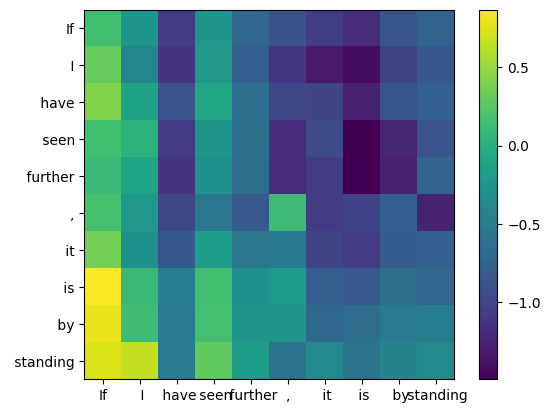

In [1616]:
import matplotlib.pyplot as plt
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [1617]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

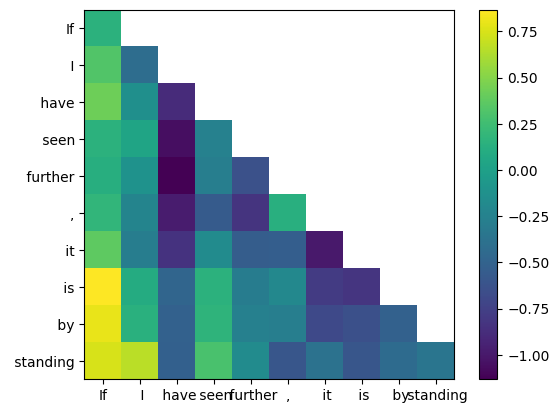

In [1618]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

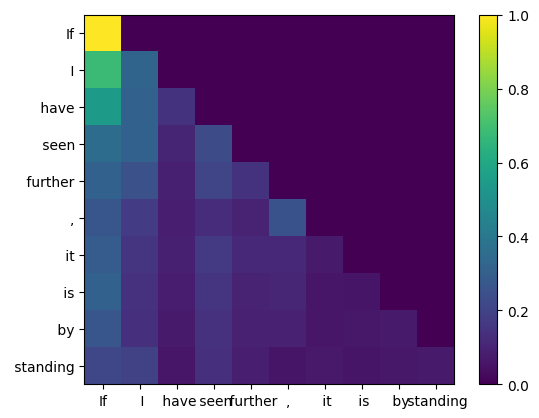

In [1619]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

### values (almost the end of attention)
these scores (0-1) are used to determine how much of value matrix is used per token
<br>
&gt; just like keys, value weights are also shared acorss every 4 attention heads (to save computation)
<br>
&gt; as a result, the shape of the value weight matrix below is [8x128x4096]


In [1620]:
v_layer0 = v_layer0.view(n_kv_heads, head_dim, dim)
print(v_layer0.shape)

torch.Size([8, 128, 4096])


the first layer, first head value weight matrix is given below

In [1621]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

### value vectors
we now use the value weghts to get the attention values per token, this is of size [10x128] where 10 is the number of tokens in the prompt and 128 is the dim of the value vector per token

In [1622]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([10, 128])

### attention
the resultant attention vector after multipying with the values per token is of shape [10*128]

In [1623]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([10, 128])

### multi head attention
We now have the attention value of the first layer and first head.
<br>
now im going to run a loop and perform the exact same math as the cells above but for every head in the first layer

In [1624]:
qkv_attention_store = []
GQA_num = n_heads // n_kv_heads # 
for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//GQA_num] 
    v_layer0_head = v_layer0[head//GQA_num]
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    position_ids = torch.arange(len(tokens))
    cos, sin = rotary_emb(position_ids)
    q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin, position_ids)  

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

we now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [10x4096]
<br>
we are almost at the end :)

In [1625]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([10, 4096])

### weight matrix, one of the final steps
one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the 

In [1626]:
w_layer0 = model["model.layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

### this is a simple linear layer, so we just matmul

In [1627]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([10, 4096])

we now have the change in the embedding value after attention, that should be adding to the original token embeddings

In [1628]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([10, 4096])

### we normalize and then run a feed forward neural network through the embedding delta

In [1629]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["model.layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([10, 4096])

### loading the ff weights and implementing the feed forward network
in internlm2.5, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model.
<br>
its pretty standard to use this feed forward network architecture in llms these days

In [1630]:
w1 = model["model.layers.0.feed_forward.w1.weight"]
w2 = model["model.layers.0.feed_forward.w2.weight"]
w3 = model["model.layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([10, 4096])

### We finally have new edited embeddings for each token after the first layer.
just 31 more layers to go before we are done (one for loop away)
<br>
you can imagine this edited embedding as having information about all queries asked on the first layer
<br>
now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need.

In [1631]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([10, 4096])

### god, everything all at once
yep, this is it. everything we did before, all at once, for every single layer.
<br>

### have fun reading :)

In [1632]:
k_cache, v_cache = [], []   # init k v cache

In [1633]:
final_embedding = token_embeddings_unnormalized
GQA_num = n_heads // n_kv_heads
for layer in range(n_layers):
    k_cache.append([])
    v_cache.append([])
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"model.layers.{layer}.attention_norm.weight"])

    qkv_layer = model[f"model.layers.{layer}.attention.wqkv.weight"]
    head_dim = dim // n_heads
    q_layer, k_layer, v_layer = qkv_layer.reshape(n_kv_heads, 2+n_heads//n_kv_heads, head_dim, dim).split([n_heads//n_kv_heads, 1, 1], dim=1)
    q_layer, k_layer, v_layer = q_layer.reshape(-1, dim), k_layer.reshape(-1, dim), v_layer.reshape(-1, dim)
    
    q_layer = q_layer.reshape(n_heads, head_dim, dim)
    k_layer = k_layer.reshape(n_kv_heads, head_dim, dim)
    v_layer = v_layer.reshape(n_kv_heads, head_dim, dim)
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//GQA_num]
        v_layer_head = v_layer[head//GQA_num]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        if head % GQA_num == 0:   # 
            v_cache[-1].append(v_per_token)   # cache v vector
            
        position_ids = torch.arange(len(tokens))
        cos, sin = rotary_emb(position_ids)
        q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin, position_ids)

        if head % GQA_num == 0:   # 
            k_cache[-1].append(k_per_token_rotated)  # cache k vector
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"model.layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.ffn_norm.weight"])
    w1 = model[f"model.layers.{layer}.feed_forward.w1.weight"] 
    w2 = model[f"model.layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"model.layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [1634]:
# k v cache info
print(k_cache[0][0].shape)
print(k_cache[0][-1].shape)
print(len(k_cache))
print(len(k_cache[0]))
print(v_cache[0][0].shape)
print(v_cache[0][-1].shape)
print(len(v_cache))
print(len(v_cache[0]))

torch.Size([10, 128])
torch.Size([10, 128])
32
8
torch.Size([10, 128])
torch.Size([10, 128])
32
8


### we now have the final embedding, the best guess the model could make about the next token
the shape of the embedding is the same as regular token embeddings [10x3854] where 10 is the number of tokens and 3584 is the embedding dim

In [1635]:
final_embedding = rms_norm(final_embedding, model["model.norm.weight"])
final_embedding.shape

torch.Size([10, 4096])

### finally, lets decode the embedding into the token value
we will use the output decoder to convert the final embedding into a token

In [1636]:
model["output.weight"].shape

torch.Size([92544, 4096])

### we use the embedding of the last token to predict the next value
hopefully in our case: on 

In [1637]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([92544])

### the model predicted token number 519 as the next token, is this the token number for on?
this is the last cell of code, hopefully you had fun :)

In [1638]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(519)

### decode output

In [1639]:
tokenizer.decode([next_token.item()])

' on'

## Prefill stage is finish, we get the k_cache and v_cache for input_token.
we also get a output(next token), and we can use it as a input token for generat next token. This is the feature for Decoder only model.
</br>预填充阶段推理完成，生成第一个token且缓存了prompt阶段过程中生成的k和v。下一阶段进行decoder推理，加载前面生成的k和v，进行加速推理。

In [1640]:
max_new_len = 6
seq_len = len(tokens)
GQA_num = n_heads // n_kv_heads 

In [1641]:
next_token = torch.tensor([next_token.item()])
for _ in range(max_new_len-1):
    print(next_token[-1].item())
    if next_token.item() == 2:    # 2 is "eos_token_id"
        break
    next_token = next_token[-1:]
    next_token_embeddings_unnormalized = embedding_layer(next_token).to(torch.bfloat16)

    final_embedding = next_token_embeddings_unnormalized
    for layer in range(n_layers):
        qkv_attention_store = []
        layer_embedding_norm = rms_norm(final_embedding, model[f"model.layers.{layer}.attention_norm.weight"])
        
        qkv_layer = model[f"model.layers.{layer}.attention.wqkv.weight"]
        q_layer, k_layer, v_layer = qkv_layer.reshape(n_kv_heads, 2+n_heads//n_kv_heads, head_dim, dim).split([n_heads//n_kv_heads, 1, 1], dim=1)
        q_layer, k_layer, v_layer = q_layer.reshape(-1, dim), k_layer.reshape(-1, dim), v_layer.reshape(-1, dim)
        
        q_layer = q_layer.reshape(n_heads, head_dim, dim)
        k_layer = k_layer.reshape(n_kv_heads, head_dim, dim)
        v_layer = v_layer.reshape(n_kv_heads, head_dim, dim)
        
        for head in range(n_heads):
            q_layer_head = q_layer[head]
            k_layer_head = k_layer[head//GQA_num]
            v_layer_head = v_layer[head//GQA_num]
            q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)

            cos, sin = rotary_emb(torch.tensor([seq_len]))
            q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin)

            if head % GQA_num == 0:
                v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
                v_cache[layer][head//GQA_num] = torch.cat([v_cache[layer][head//GQA_num], v_per_token], dim=0)    # update v_cache

                k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)   
                q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin)
                k_cache[layer][head//GQA_num] = torch.cat([k_cache[layer][head//GQA_num], k_per_token_rotated], dim=0)    # update k_cache
                
            qk_per_token = torch.matmul(q_per_token_rotated, k_cache[layer][head//GQA_num].T)/(128)**0.5
            #mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))   # don't need mask
            #mask = torch.triu(mask, diagonal=1)
            qk_per_token_after_masking = qk_per_token  # + mask
            qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
            qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_cache[layer][head//GQA_num])
            qkv_attention_store.append(qkv_attention)

        stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
        w_layer = model[f"model.layers.{layer}.attention.wo.weight"]
        embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
        embedding_after_edit = final_embedding + embedding_delta
        embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.ffn_norm.weight"])
        w1 = model[f"model.layers.{layer}.feed_forward.w1.weight"]
        w2 = model[f"model.layers.{layer}.feed_forward.w2.weight"]
        w3 = model[f"model.layers.{layer}.feed_forward.w3.weight"]
        output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
        final_embedding = embedding_after_edit+output_after_feedforward
    
    final_embedding = rms_norm(final_embedding, model["model.norm.weight"])
    logits = torch.matmul(final_embedding, model["output.weight"].T)
    next_token = torch.argmax(logits, dim=-1)
    print("token decode: ", tokenizer.decode([next_token.item()]))
    seq_len += 1

519
token decode:   the
410
token decode:   shoulders
27315
token decode:   of
446
token decode:   giants
44722
token decode:  .


thank you, i love you :)

This is the end. Hopefully you enjoyed reading it!